In [1]:
import math
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import numpy as np
import seaborn as sns

from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.compat import lzip
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

Text(0, 0.5, 'chill (degrees C)')

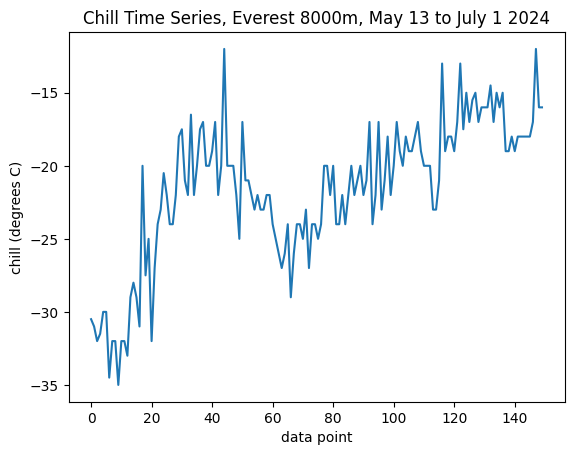

In [2]:
chill = pd.read_csv('data_csvs/everest_8000m_chill_time_series.csv')
chill['chill'].plot()
plt.title('Chill Time Series, Everest 8000m, May 13 to July 1 2024')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')

Text(0, 0.5, 'log(chill)')

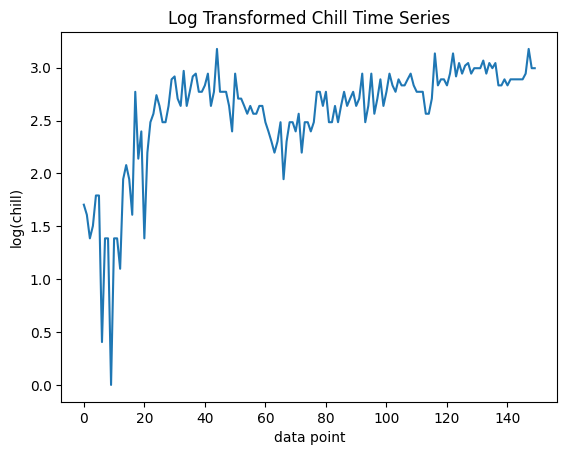

In [3]:
# Now let's do a log transformation.
translation_length = min(chill['chill']) - 1
chill_translated = chill['chill'] - translation_length
chill_log = np.log(chill_translated)
chill_log.plot()
plt.title('Log Transformed Chill Time Series')
plt.xlabel('data point')
plt.ylabel('log(chill)')

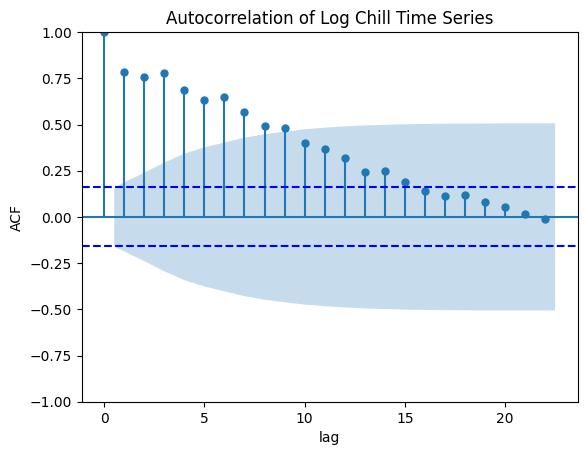

In [4]:
plot_acf(chill_log, alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Autocorrelation of Log Chill Time Series')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show()

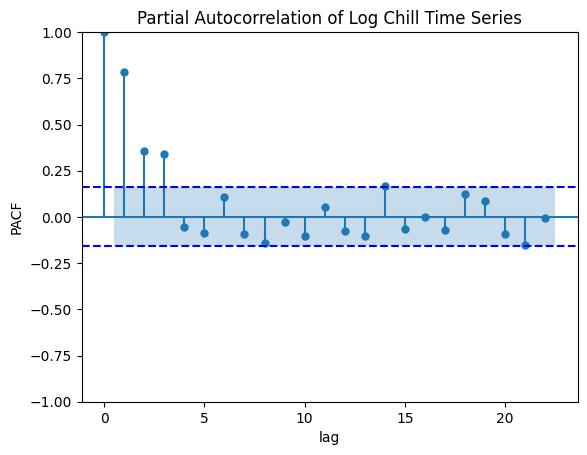

In [5]:
plot_pacf(chill_log, alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Partial Autocorrelation of Log Chill Time Series')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

In [6]:
# These plots suggest an AR(3) model.

In [7]:
# Let's investigate a wider hyperparameter space: let's do a matrix with p = 0 to 9 and d = 0 to 2.
# For each, fit the model and determine the BIC and AIC. Then see which model is found to be optimal by these criteria.
hyperparam_results = pd.DataFrame(columns=['p', 'd', 'BIC', 'AIC'])
aic_plot = pd.DataFrame({'0': [0] * 10, '1': [0] * 10, '2': [0] * 10})
bic_plot = pd.DataFrame({'0': [0] * 10, '1': [0] * 10, '2': [0] * 10})

for p in range(10):
    for d in range(3):
        arima_fit = ARIMA(chill_log, order=(p,d,0)).fit()
        hyperparam_results.loc[len(hyperparam_results.index)] = [p, d, arima_fit.bic, arima_fit.aic]
        aic_plot.iloc[p, d] = arima_fit.aic
        bic_plot.iloc[p, d] = arima_fit.bic

print(hyperparam_results)

c:\users\pmwad\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


      p    d         BIC         AIC
0   0.0  0.0  230.559952  224.538682
1   0.0  1.0   89.626846   86.622900
2   0.0  2.0  248.272074  245.274862
3   1.0  0.0   85.916763   76.884857
4   1.0  1.0   59.996482   53.988589
5   1.0  2.0  186.057556  180.063131
6   2.0  0.0   65.984714   53.942173
7   2.0  1.0   30.576838   21.564999
8   2.0  2.0  111.843840  102.852203
9   3.0  0.0   40.778618   25.725442
10  3.0  1.0   35.329175   23.313390
11  3.0  2.0   82.293635   70.304786
12  4.0  0.0   45.697833   27.634021
13  4.0  1.0   39.527791   24.508060
14  4.0  2.0   81.670765   66.684703
15  5.0  0.0   49.522813   28.448366
16  5.0  1.0   43.215753   25.192075
17  5.0  2.0   79.860840   61.877567
18  6.0  0.0   53.583786   29.498704
19  6.0  1.0   47.839434   26.811810
20  6.0  2.0   73.779776   52.799290
21  7.0  0.0   58.448759   31.353042
22  7.0  1.0   52.066825   28.035255
23  7.0  2.0   75.693358   51.715659
24  8.0  0.0   62.168806   32.062453
25  8.0  1.0   57.062996   30.027479
2

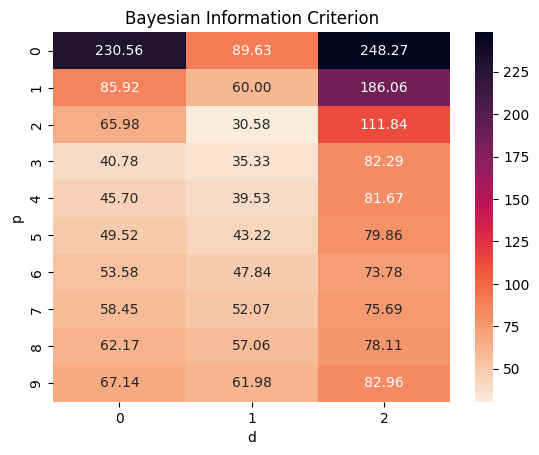

In [8]:
sns.heatmap(bic_plot, annot=True, cmap=sns.cm.rocket_r, fmt='.2f')
plt.xlabel('d')
plt.ylabel('p')
plt.title('Bayesian Information Criterion')
plt.show()

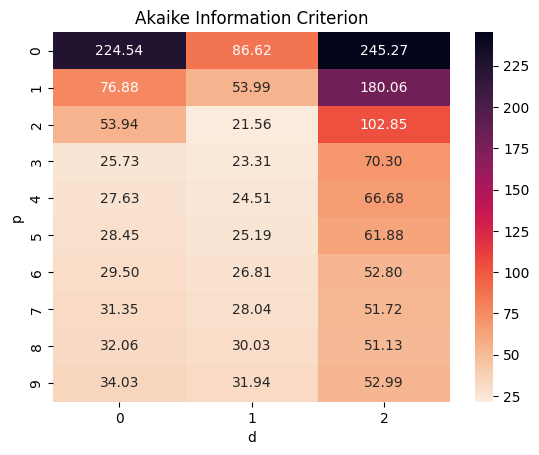

In [9]:
sns.heatmap(aic_plot, annot=True, cmap=sns.cm.rocket_r, fmt='.2f')
plt.xlabel('d')
plt.ylabel('p')
plt.title('Akaike Information Criterion')
plt.show()

In [10]:
# Our matrix suggests that ARIMA(2,1,0) is best, as with the not-log-transformed chill data.
chill_arima_2_1_0 = ARIMA(chill_log, order=(2,1,0))
chill_arima_2_1_0_fit = chill_arima_2_1_0.fit()

# Model results:
print(chill_arima_2_1_0_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  chill   No. Observations:                  150
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  -7.782
Date:                Tue, 13 Aug 2024   AIC                             21.565
Time:                        11:57:50   BIC                             30.577
Sample:                             0   HQIC                            25.226
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6628      0.059    -11.171      0.000      -0.779      -0.547
ar.L2         -0.4529      0.042    -10.877      0.000      -0.535      -0.371
sigma2         0.0647      0.004     17.948      0.0

Text(0, 0.5, 'residual')

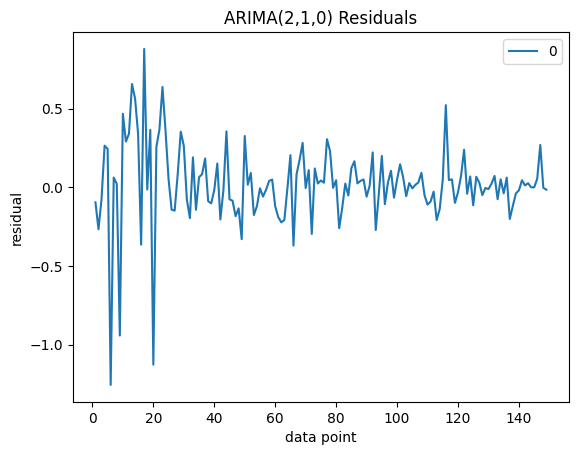

In [11]:
# Residuals
chill_arima_2_1_0_res = pd.DataFrame(chill_arima_2_1_0_fit.resid[1:])
chill_arima_2_1_0_res.plot()
plt.title('ARIMA(2,1,0) Residuals')
plt.xlabel('data point')
plt.ylabel('residual')

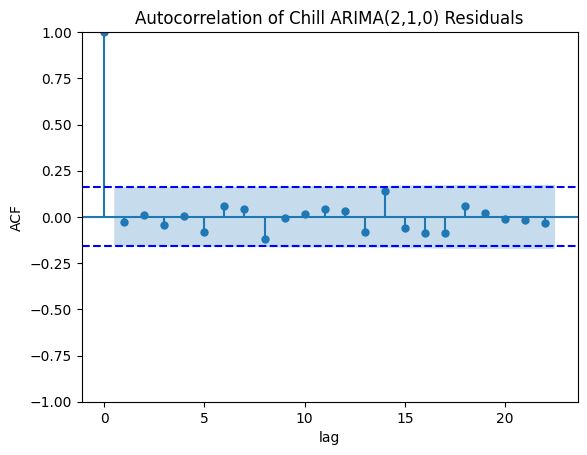

In [12]:
plot_acf(chill_arima_2_1_0_res, alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Autocorrelation of Chill ARIMA(2,1,0) Residuals')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.show()

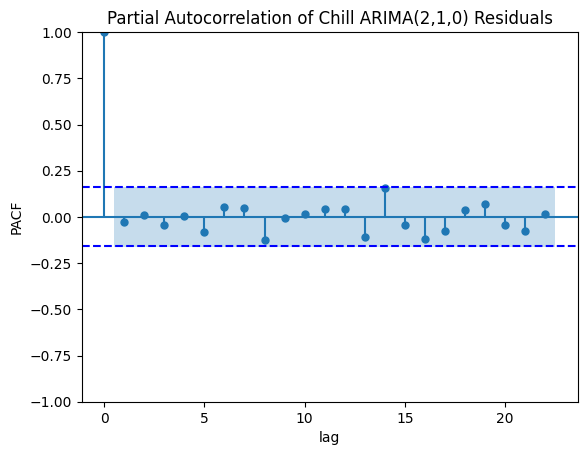

In [13]:
plot_pacf(chill_arima_2_1_0_res, alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Partial Autocorrelation of Chill ARIMA(2,1,0) Residuals')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.show()

In [14]:
# Let's see what the Ljung-Box test has to say:
acorr_ljungbox(chill_arima_2_1_0_res)

,lb_stat,lb_pvalue
1,0.098503,0.753634
2,0.116925,0.943214
3,0.448827,0.929981
4,0.452440,0.977963
5,1.526169,0.910030
6,2.039111,0.916067
7,2.346321,0.938218
8,4.521850,0.807243
9,4.526090,0.873512
10,4.573260,0.917805


In [15]:
# Evaluate the homoscedasticity of the residuals by Breusch-Pagan test:
print('Mean of the residuals: ' + str(chill_arima_2_1_0_res[0].mean(axis=0)) + '\n')
bp_df = chill_arima_2_1_0_res.copy()
bp_df.columns = ['resid']
bp_df.insert(loc=0, column = 'index', value=bp_df.index.to_numpy())
bp_fit = smf.ols('resid ~ index', data=bp_df).fit()
print(bp_fit.summary())

names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_result = sms.het_breuschpagan(bp_fit.resid, bp_fit.model.exog)
lzip(names, bp_result)

Mean of the residuals: 0.019017497743603517

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2294
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.633
Time:                        11:57:51   Log-Likelihood:                -7.0418
No. Observations:                 149   AIC:                             18.08
Df Residuals:                     147   BIC:                             24.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

[('Lagrange multiplier statistic', 16.335862524928604),
 ('p-value', 5.3050434061186085e-05),
 ('f-value', 18.10113748047201),
 ('f p-value', 3.712341253815549e-05)]

In [16]:
# There, now we have a model that has residuals that are homoscedastic and without any apparent autocorrelation!!

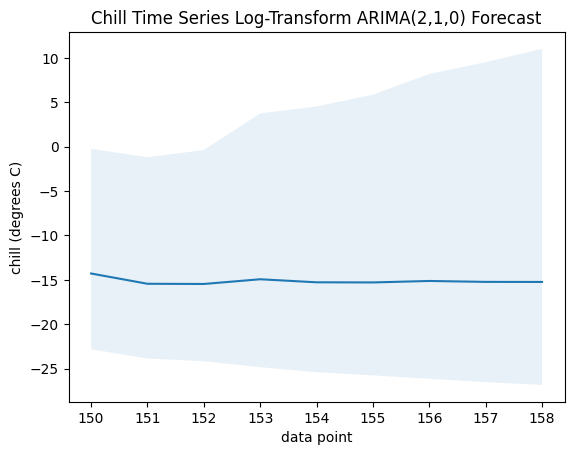

In [17]:
# Now to make forecasts.
chill_log_arima_fores = chill_arima_2_1_0_fit.forecast(steps=9)
ci = chill_arima_2_1_0_fit.get_forecast(steps=9).conf_int(alpha=0.05)

# Of course that is on the scale of the transformed data, we need to back-transform it.
chill_log_arima_fores_backtransf = chill_log_arima_fores.apply(math.exp) + translation_length
ci_backtransf = pd.DataFrame()
ci_backtransf['lower chill'] = ci['lower chill'].apply(math.exp) + translation_length
ci_backtransf['upper chill'] = ci['upper chill'].apply(math.exp) + translation_length

# Create confidence interval plot.
fig, ax = plt.subplots()
ax.plot(chill_log_arima_fores_backtransf.index, chill_log_arima_fores_backtransf)
ax.fill_between(ci_backtransf.index, ci_backtransf['lower chill'], ci_backtransf['upper chill'], alpha=0.1)

plt.title('Chill Time Series Log-Transform ARIMA(2,1,0) Forecast')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')
plt.show()

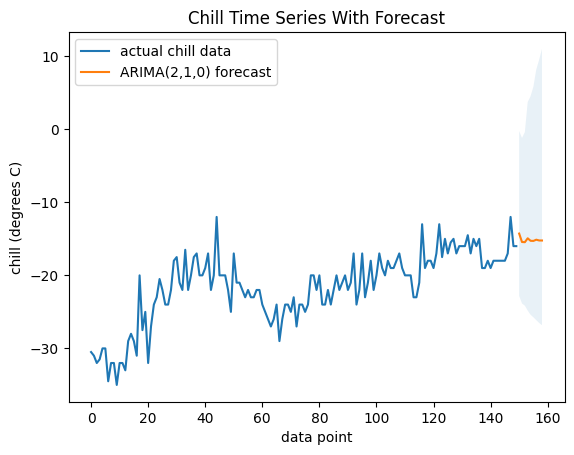

In [18]:
# Now let's plot it alongside the actual data:
fig, ax = plt.subplots()
ax.plot(chill.index, chill['chill'], label='actual chill data')
ax.plot(chill_log_arima_fores_backtransf.index, chill_log_arima_fores_backtransf, label='ARIMA(2,1,0) forecast')
ax.legend(loc='upper left')
ax.fill_between(ci_backtransf.index, ci_backtransf['lower chill'], ci_backtransf['upper chill'], alpha=0.1)

plt.title('Chill Time Series With Forecast')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')
plt.show()

In [19]:
# Well, it seems generally sensible to me. The confidence interval is very very wide and not even on both sides. This makes some sense, considering the upward trend in the data.

In [20]:
# Now, let's compare the forecast to the actual chill from those days. 

# Append "next 12 points" to chill time series and plot
# calculate error by different metrics
# compare error to the mountain-forecast.com error

In [21]:
chill_next_12 = pd.read_csv('data_csvs/everest_8000m_chill_time_series_next_12_points.csv')
chill_next_12['index'] = chill_next_12.index + 150
chill_next_9 = chill_next_12.iloc[:9]
print(chill_next_9)

  local_time_of_forecast  chill  index
0    2024-07-02T07:00:00  -15.0    150
1    2024-07-02T15:00:00  -11.0    151
2    2024-07-02T23:00:00  -11.0    152
3    2024-07-03T15:00:00  -11.0    153
4    2024-07-03T23:00:00  -19.0    154
5    2024-07-04T07:00:00  -19.5    155
6    2024-07-04T15:00:00  -12.0    156
7    2024-07-04T23:00:00  -20.0    157
8    2024-07-05T07:00:00  -18.5    158


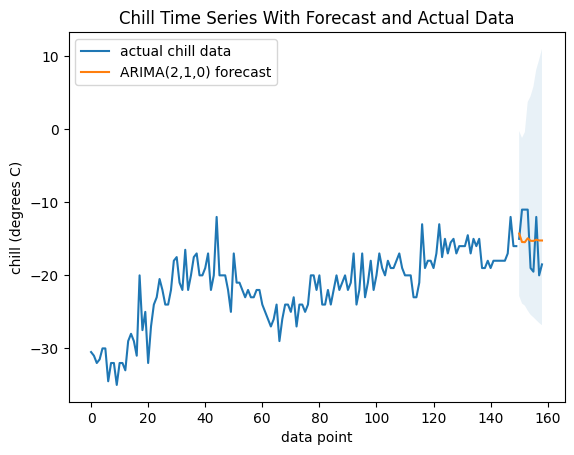

In [22]:
fig, ax = plt.subplots()
ax.plot(chill.index, chill['chill'])
ax.plot(chill_next_9['index'], chill_next_9['chill'], color='#1f77b4', label='actual chill data')
ax.plot(chill_log_arima_fores_backtransf.index, chill_log_arima_fores_backtransf, label='ARIMA(2,1,0) forecast')
ax.legend(loc='upper left')
ax.fill_between(ci_backtransf.index, ci_backtransf['lower chill'], ci_backtransf['upper chill'], alpha=0.1)

plt.title('Chill Time Series With Forecast and Actual Data')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')
plt.show()

In [23]:
# Well, the actual data certainly stays within the bounds of the 95% confidence interval of the forecast. 

In [24]:
# Compute the RMSE:
arima_rms = mean_squared_error(chill_next_9['chill'], chill_log_arima_fores_backtransf, squared=False)
print(arima_rms)

3.806873871215987


In [25]:
# Let's consider the actual forecast issued on mountain-forecast.com issued on the night of July 1:
mf_forecast_full = pd.read_csv('data_csvs/everest_8000m_time_series_mountain-weather_forecast_of_next_12_points.csv')
mf_forecast_chill = pd.DataFrame(mf_forecast_full['chill'][1:10])
mf_forecast_chill['local_time_of_forecast'] = mf_forecast_full['local_time_of_forecast'][1:10]
mf_forecast_chill['index'] = mf_forecast_chill.index + 149

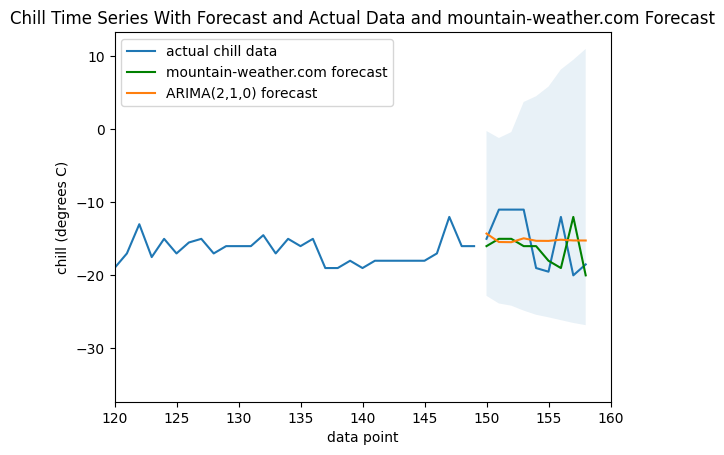

In [26]:
fig, ax = plt.subplots()
ax.plot(chill.index, chill['chill'])
ax.plot(chill_next_9['index'], chill_next_9['chill'], color='#1f77b4', label='actual chill data')
ax.plot(mf_forecast_chill['index'], mf_forecast_chill['chill'], color='green', label='mountain-weather.com forecast')
ax.plot(chill_log_arima_fores_backtransf.index, chill_log_arima_fores_backtransf, color='#ff7f0e', label='ARIMA(2,1,0) forecast')
ax.legend(loc='upper left')
ax.fill_between(ci_backtransf.index, ci_backtransf['lower chill'], ci_backtransf['upper chill'], alpha=0.1)

plt.title('Chill Time Series With Forecast and Actual Data and mountain-weather.com Forecast')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')
plt.xlim(120,160)
plt.show()

In [27]:
# The mountain-forecast.com forecast captures the shape of the upcoming chill plot fairly well, seemingly better than our ARIMA model.
# However, over the following 9 data points at least, the RMSE is actually greater than for our model:
mf_rms = mean_squared_error(chill_next_9['chill'], mf_forecast_chill['chill'], squared=False)
print(mf_rms)

4.527692569068709


In [28]:
# We should also consider a naive model, picking just the last chill value observed:
naive_forecast = pd.Series([chill['chill'][149]] * 9)
naive_rms = mean_squared_error(chill_next_9['chill'], naive_forecast, squared=False)
print(naive_rms)

3.8801489089409387


In [29]:
# Indeed the Naive model's performance is very close to the ARIMA model.

In [30]:
# To investigate this more closely, we can use rolling origin cross-validation:
tscv = TimeSeriesSplit(n_splits=16, test_size=9)
cv_results = pd.DataFrame(columns=['last training set index', 'ARIMA RMSE', 'Naive RMSE'])

for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
    # Generate ARIMA model
    # Translate and log-transform the data
    chill_data = chill['chill'][train_index]
    chill_data_translated = chill_data - translation_length
    chill_data_log = np.log(chill_data_translated)

    chill_arima_2_1_0 = ARIMA(chill_data_log, order=(2,1,0))
    chill_arima_2_1_0_fit = chill_arima_2_1_0.fit()
    chill_log_arima_fores = chill_arima_2_1_0_fit.forecast(steps=9)
    # Back-transform the forecast
    chill_log_arima_fores_backtransf = chill_log_arima_fores.apply(math.exp) + translation_length
    arima_rmse = mean_squared_error(chill.iloc[test_index]['chill'], chill_log_arima_fores_backtransf, squared=False)
    
    # Generate Naive model
    naive_fores = pd.Series(
        [chill.iloc[train_index[-1]]['chill']] 
        * len(test_index)
    )
    naive_rmse = mean_squared_error(chill.iloc[test_index]['chill'], naive_fores, squared=False)

    cv_results.loc[i] = [train_index[-1], arima_rmse, naive_rmse]

print(cv_results)

c:\users\pmwad\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


    last training set index  ARIMA RMSE  Naive RMSE
0                       5.0    2.368032    2.891559
1                      14.0    5.046068    3.961621
2                      23.0    3.825024    2.798809
3                      32.0    2.571124    3.674235
4                      41.0    3.587130    4.409586
5                      50.0    1.534515    5.163978
6                      59.0    3.778892    3.986087
7                      68.0    2.611325    1.763834
8                      77.0    1.727560    2.581989
9                      86.0    2.311883    2.309401
10                     95.0    1.593495    3.349959
11                    104.0    1.672019    2.134375
12                    113.0    4.861613    5.981453
13                    122.0    1.050090    3.223180
14                    131.0    2.006932    2.006932
15                    140.0    2.681886    2.905933


In [31]:
# For getting the actual moutain-weather.com forecasts that correspond to the last time of the training set:
# print(chill['local_time_of_forecast (Date Hour)'][cv_results['last training set index']])

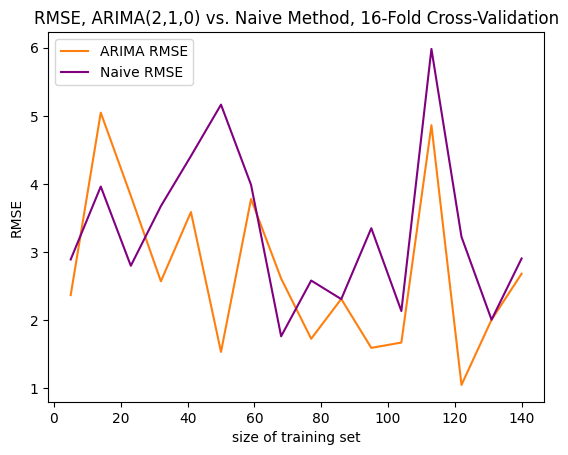

In [32]:
fig, ax = plt.subplots()
ax.plot(cv_results['last training set index'], cv_results['ARIMA RMSE'], color='#ff7f0e', label='ARIMA RMSE')
ax.plot(cv_results['last training set index'], cv_results['Naive RMSE'], color='purple', label='Naive RMSE')
ax.legend()

plt.title('RMSE, ARIMA(2,1,0) vs. Naive Method, 16-Fold Cross-Validation')
plt.ylabel('RMSE')
plt.xlabel('size of training set')
plt.show()

In [33]:
# So, when evaluating over the whole range of our data by cross-validation, it is clear that this method is a significant improvement on the Naive method.
print('Mean ARIMA(2,1,0) RMSE: ' + str(cv_results['ARIMA RMSE'].mean()))
print('Mean Naive RMSE: ' + str(cv_results['Naive RMSE'].mean()))

Mean ARIMA(2,1,0) RMSE: 2.701724341220853
Mean Naive RMSE: 3.3214330890789387


In [34]:
# Also, when discounting the first two training sets, which are very small, the mean ARIMA RMSE decreases to around 2.5.

In [ ]:
# Let's also look at the grid search for cross-validation.
# This time I've decided to skip the first two splits because the training set is very small.
# Turn off warnings because a lot of them pop up for various ARIMA fits at various start points...
warnings.filterwarnings('ignore')

tscv = TimeSeriesSplit(n_splits=16, test_size=9)
ps = []
d1_rmses = []

print('ARIMA models, 16-fold CV skipping the first two:')
for p in range(21):
    for d in range(3):
        rmses = pd.Series()
        for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
            if i == 0 or i == 1:
                continue
            # Generate ARIMA model
            # Translate and log-transform the data
            chill_data = chill['chill'][train_index]
            chill_data_translated = chill_data - translation_length
            chill_data_log = np.log(chill_data_translated)

            chill_arima = ARIMA(chill_data_log, order=(p,d,0))
            chill_arima_fit = chill_arima.fit()
            chill_log_arima_fores = chill_arima_fit.forecast(steps=9)
            # Back-transform the forecast
            chill_log_arima_fores_backtransf = chill_log_arima_fores.apply(math.exp) + translation_length
            arima_rmse = mean_squared_error(chill.iloc[test_index]['chill'], chill_log_arima_fores_backtransf, squared=False)
            rmses.loc[i] = arima_rmse
        mean_rmse = rmses.mean()
        if d == 1:
            ps.append(p)
            d1_rmses.append(mean_rmse)
        print('p: ' + str(p) + '  d: ' + str(d) + '  Mean RMSE: ' + str(mean_rmse))
    print()

# This is for plotting below
mean_rmse_for_d1 = pd.DataFrame({'p': ps, 'mean RMSE': d1_rmses})
    
warnings.filterwarnings('default')
print('Naive model, 16-fold CV skipping the first two:')
print('Mean RMSE: ' + str(cv_results['Naive RMSE'][2:].mean()))

ARIMA models, 16-fold CV skipping the first two:
p: 0  d: 0  Mean RMSE: 6.128546799345201
p: 0  d: 1  Mean RMSE: 3.3064106706032286
p: 0  d: 2  Mean RMSE: 104.99562498966768

p: 1  d: 0  Mean RMSE: 4.97285927082691
p: 1  d: 1  Mean RMSE: 2.730417123171492
p: 1  d: 2  Mean RMSE: 28.195265633673046

p: 2  d: 0  Mean RMSE: 4.003836668399553
p: 2  d: 1  Mean RMSE: 2.5581063988842874
p: 2  d: 2  Mean RMSE: 17.56984624807111

p: 3  d: 0  Mean RMSE: 3.2311603990525173
p: 3  d: 1  Mean RMSE: 2.5921834809609474
p: 3  d: 2  Mean RMSE: 7.851621804977393

p: 4  d: 0  Mean RMSE: 3.2189210284472063
p: 4  d: 1  Mean RMSE: 2.5705598933542713
p: 4  d: 2  Mean RMSE: 5.965759888737634

p: 5  d: 0  Mean RMSE: 3.3725914488129445
p: 5  d: 1  Mean RMSE: 2.547257410462205
p: 5  d: 2  Mean RMSE: 4.2049524153920865

p: 6  d: 0  Mean RMSE: 3.340859502186878
p: 6  d: 1  Mean RMSE: 2.5655110825183884
p: 6  d: 2  Mean RMSE: 3.8252850963529146

p: 7  d: 0  Mean RMSE: 3.3794287897756092
p: 7  d: 1  Mean RMSE: 2.58911

In [ ]:
# This validates our selection of the ARIMA(2,1,0) model. While increasing p might slightly lower apparent RMSE, such as for ARIMA(5,1,0) and ARIMA(13,1,0), 
# this difference is fairly small. Therefore, it is best to select the model with fewer terms/lower complexity.
# Clearly extreme overfitting begins after p = 17.
# Values of d other than 1 do not seem to offer any improvement, and these models are strictly worse than those with d = 1.
fig, ax = plt.subplots()
ax.plot(mean_rmse_for_d1['p'], mean_rmse_for_d1['mean RMSE'])

plt.title('Mean RMSE for ARIMA(p,1,0) Models')
plt.ylabel('Mean RMSE')

plt.xlabel('p')
plt.ylim(2.25,4)
plt.xlim(0,18)
plt.xticks(np.arange(min(mean_rmse_for_d1['p']), 18, 1.0))
plt.show()

In [ ]:
# Clearly when p gets to around 8, we begin seriously overfitting, causing the CV RMSE to rise.
# p = 2 is clearly shown to be optimal, since there is no significant improvement through p = 7.

In [ ]:
# Does adding a moving average part improve things?
warnings.filterwarnings('ignore')

tscv = TimeSeriesSplit(n_splits=16, test_size=9)
qs = []
q_mean_rmses = []

print('ARIMA models, 16-fold CV skipping the first two:')
for q in range(16):
    rmses = pd.Series()
    for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
        if i == 0 or i == 1:
            continue
        # Generate ARIMA model
        # Translate and log-transform the data
        chill_data = chill['chill'][train_index]
        chill_data_translated = chill_data - translation_length
        chill_data_log = np.log(chill_data_translated)

        chill_arima = ARIMA(chill_data_log, order=(2,1,q))
        chill_arima_fit = chill_arima.fit()
        chill_log_arima_fores = chill_arima_fit.forecast(steps=9)
        # Back-transform the forecast
        chill_log_arima_fores_backtransf = chill_log_arima_fores.apply(math.exp) + translation_length
        arima_rmse = mean_squared_error(chill.iloc[test_index]['chill'], chill_log_arima_fores_backtransf, squared=False)
        rmses.loc[i] = arima_rmse
    mean_rmse = rmses.mean()
    print('q: ' + str(q) + '  Mean RMSE: ' + str(mean_rmse))
    qs.append(q)
    q_mean_rmses.append(mean_rmse)

print()
    
warnings.filterwarnings('default')
print('Naive model, 16-fold CV skipping the first two:')
print('Mean RMSE: ' + str(cv_results['Naive RMSE'][2:].mean()))

In [ ]:
# So, just to check, adding moving average does not offer any improvement.
# Let's just plot it:
fig, ax = plt.subplots()
ax.plot(qs, q_mean_rmses)

plt.title('Mean RMSE for ARIMA(2,1,q) Models')
plt.ylabel('Mean RMSE')

plt.xlabel('q')
# plt.ylim(2.25,4)
# plt.xlim(0,18)
# plt.xticks(np.arange(min(mean_rmse_for_d1['p']), 18, 1.0))
plt.show()

In [ ]:
# Let's see how the mountain-weather.com forecasts compare:
tscv = TimeSeriesSplit(n_splits=16, test_size=9)

mf_forecasts = {}
for csv in os.listdir('data_csvs/mf_forecasts_for_cv'):
    # skip .ipynb_checkpoints etc.
    if csv[0] == '.':
        continue
    df = pd.read_csv(f'data_csvs/mf_forecasts_for_cv/{csv}')
    mf_forecasts[csv[:-4]] = df['chill'].iloc[1:10]    
    

mf_rmses = []
for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
    mf_forecast = mf_forecasts[str(train_index[-1])]
    mf_rmse = mean_squared_error(chill.iloc[test_index]['chill'], mf_forecast, squared=False)
    mf_rmses.append(mf_rmse)
    
mf_mean_rmse = pd.Series(mf_rmses).mean()
print(f'Mean mountain-forecast.com forecast RMSE: {mf_mean_rmse}')    

In [ ]:
# So, for this time series, over the subsequent 9 points, the ARIMA(2,1,0) model actually outperforms the forecasts on mountain-forecast.com!

In [ ]:
# # Checking our work:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=16, test_size=9)

# import os
# mf_forecasts = {}
# mf_times = {}
# for csv in os.listdir('data_csvs/mf_forecasts_for_cv'):
#     # skip .ipynb_checkpoints etc.
#     if csv[0] == '.':
#         continue
#     df = pd.read_csv(f'data_csvs/mf_forecasts_for_cv/{csv}')
#     mf_forecasts[csv[:-4]] = df['chill'].iloc[1:10]
    
#     mf_times[csv[:-4]] = df['local_time_of_forecast'].iloc[1:10]
    

# mf_rmses = []
# for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
#     mf_forecast = mf_forecasts[str(train_index[-1])]
#     mf_rmse = mean_squared_error(chill.iloc[test_index]['chill'], mf_forecast, squared=False)
#     mf_rmses.append(mf_rmse)
    
#     print(mf_times[str(train_index[-1])])
#     print(chill.iloc[test_index]['local_time_of_forecast (Date Hour)'])
#     print()
    
# mf_mean_rmse = pd.Series(mf_rmses).mean()
# print(f'Mean mountain-forecast.com forecast RMSE: {mf_mean_rmse}')    

In [ ]:
# I would predict that the ARIMA model does not forecast as well if we are predicting 12, 15, 18 or more points into the future.
# This is because it tends to flatten out, while I believe the mountain-forecast.com forecasts predict shape more closely.

# SO evaluate more points ahead...

In [ ]:
# Let's also look at the grid search for cross-validation.
# This time I've decided to skip the first two splits because the training set is very small.
# Turn off warnings because a lot of them pop up for various ARIMA fits at various start points...
warnings.filterwarnings('ignore')

arima_rmses_for_plot = []
naive_rmses_for_plot = []
for steps in range(1, 22):
    tscv = TimeSeriesSplit(n_splits=7, test_size=steps)
    arima_rmses = pd.Series()
    naive_rmses = pd.Series()
    for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
        # Generate ARIMA model
        # Translate and log-transform the data
        chill_data = chill['chill'][train_index]
        chill_data_translated = chill_data - translation_length
        chill_data_log = np.log(chill_data_translated)

        chill_arima = ARIMA(chill_data_log, order=(2,1,0))
        chill_arima_fit = chill_arima.fit()
        chill_log_arima_fores = chill_arima_fit.forecast(steps=steps)
        # Back-transform the forecast
        chill_log_arima_fores_backtransf = chill_log_arima_fores.apply(math.exp) + translation_length
        arima_rmse = mean_squared_error(chill.iloc[test_index]['chill'], chill_log_arima_fores_backtransf, squared=False)
        arima_rmses.loc[i] = arima_rmse
        
        # Generate Naive model
        naive_fores = pd.Series(
            [chill.iloc[train_index[-1]]['chill']] 
            * len(test_index)
        )    
        naive_rmse = mean_squared_error(chill.iloc[test_index]['chill'], naive_fores, squared=False)
        naive_rmses.loc[i] = naive_rmse
    
    arima_mean_rmse = arima_rmses.mean()
    arima_rmses_for_plot.append(arima_mean_rmse)
    # print(f'steps: {steps}')
    # print(f'Mean ARIMA RMSE: {arima_mean_rmse}')
    
    naive_mean_rmse = naive_rmses.mean()
    naive_rmses_for_plot.append(naive_mean_rmse)
    # print(f'Naive RMSE:      {naive_mean_rmse}')
    # print()

    
warnings.filterwarnings('default')

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1,22), naive_rmses_for_plot, color='purple', label='Naive RMSE')
ax.plot(range(1,22), arima_rmses_for_plot, color='#ff7f0e', label='ARIMA RMSE')
ax.legend()

plt.title('Mean RMSE, ARIMA(2,1,0) vs. Naive Method, 1 to 21 Step Forecasting')
plt.ylabel('Mean RMSE')
plt.xlabel('test set size')
plt.xticks(np.arange(1, 22, 2.0))
plt.show()

In [ ]:
# Of course both clearly trend upwards as a function of step size, but the ARIMA model consistently outperforms the Naive model.

In [ ]:
# To see the breakdown in training/test sets, uncomment:
# for steps in range(1, 22):
#     tscv = TimeSeriesSplit(n_splits=7, test_size=steps)
#     print(f'\n{steps} steps')
#     print('========================================================================================')
#     for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
#         print('train_index: ' + str(train_index))
#         print('test_index: ' + str(test_index))
#         print()

In [ ]:
# To determine the indexes for the mountain-weather.com forecasts we need, uncomment:
# indexes = set()

# for steps in range(1, 22):
#     tscv = TimeSeriesSplit(n_splits=7, test_size=steps)
    
#     for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
#         indexes.add(train_index[-1])
# print(indexes)

In [ ]:
mf_rmses_for_plot = []
for steps in range(1, 22):
    tscv = TimeSeriesSplit(n_splits=7, test_size=steps)

    mf_forecasts = {}
    for csv in os.listdir('data_csvs/mf_forecasts_for_cv'):
        # skip .ipynb_checkpoints etc.
        if csv[0] == '.':
            continue
        df = pd.read_csv(f'data_csvs/mf_forecasts_for_cv/{csv}')
        mf_forecasts[csv[:-4]] = df['chill'].iloc[1:(1+steps)]    
    # print(mf_forecasts.keys())
    
    mf_rmses = []
    for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
        mf_forecast = mf_forecasts[str(train_index[-1])]
        mf_rmse = mean_squared_error(chill.iloc[test_index]['chill'], mf_forecast, squared=False)
        mf_rmses.append(mf_rmse)

    mf_mean_rmse = pd.Series(mf_rmses).mean()
    mf_rmses_for_plot.append(mf_mean_rmse)
    print(f'Steps: {steps}      Mean mountain-forecast.com forecast RMSE: {mf_mean_rmse}')    


In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1,22), naive_rmses_for_plot, color='purple', label='Naive RMSE')
ax.plot(range(1,22), arima_rmses_for_plot, color='#ff7f0e', label='ARIMA RMSE')
ax.plot(range(1,22), mf_rmses_for_plot, color='green', label='mountain-forecast.com RMSE')
ax.legend()

plt.title('Mean RMSE, ARIMA(2,1,0) vs. Naive Method vs. mountain-forecast.com')
plt.ylabel('Mean RMSE')
plt.xlabel('test set size')
plt.xticks(np.arange(1, 22, 2.0))
plt.show()

In [ ]:
# Interesting! The ARIMA method is at least as good as mountain-forecast.com and arguably better in terms of chill RMSE.
# However, after around predictions of size 16, mountain-forecast.com seems to significantly improve upon the ARIMA model and the Naive method.

In [ ]:
# tscv = TimeSeriesSplit(n_splits=7, test_size=steps)
# for i, [train_index, test_index] in enumerate(tscv.split(chill['chill'])):
#     print(train_index)


        # print(chill_log_arima_fores_backtransf[test_index])
        # print(chill.iloc[test_index])
        # print(mean_squared_error(chill.iloc[test_index]['chill'], [chill_log_arima_fores_backtransf[test_index]], squared=False))
        # print()

In [ ]:
# ok here's what we'll do
# fixed training set size of up to 114 (150-36)
# then show the RMSE for the prediction of size 1 with a gap of 0, 1, 2, ..., 35
def add_gap_rmse(d, gap, rmse):
    if gap not in d.keys():
        d[gap] = [rmse]
    else:
        d[gap].append(rmse)
        
        
def compute_mean_rmses_per_gap(d):
    res = []
    for key in d.keys():
        res.append(pd.Series(d[key]).mean())
    return res

        
warnings.filterwarnings('ignore')

arima_rmses_per_gap = {}
naive_rmses_per_gap = {}
mf_rmses_per_gap = {}

# Use training sets of size 64 to 113
for e in range(1, 51):
    train_index = list(range(0, 64 + e))
    # Calculate RMSE for a test set of size 1 at varying gaps between training and test set
    # between 1 and 30
    for g in range(1, 31):
        test_index = [train_index[-1] + g]
        
        # Generate ARIMA model
        # Translate and log-transform the data
        chill_data = chill['chill'][train_index]
        chill_data_translated = chill_data - translation_length
        chill_data_log = np.log(chill_data_translated)

        chill_arima = ARIMA(chill_data_log, order=(2,1,0))
        chill_arima_fit = chill_arima.fit()
        chill_log_arima_fores = chill_arima_fit.forecast(steps=31)
        # Back-transform the forecast
        chill_log_arima_fores_backtransf = chill_log_arima_fores.apply(math.exp) + translation_length
        
        add_gap_rmse(
            arima_rmses_per_gap,
            g,
            mean_squared_error(chill.iloc[test_index]['chill'], [chill_log_arima_fores_backtransf[test_index]], squared=False)
        )
        
        # Generate Naive model
        naive_fores = pd.Series(
            [chill.iloc[train_index[-1]]['chill']] 
            * len(test_index)
        )    
        add_gap_rmse(
            naive_rmses_per_gap,
            g,
            mean_squared_error(chill.iloc[test_index]['chill'], naive_fores, squared=False)
        )
        
        # Determine RMSE from mountain-forecast.com's forecast 
        mf_forecast = [pd.read_csv(f'data_csvs/mf_forecasts_for_cv/{train_index[-1]}.csv')['chill'].iloc[g]]
                
        add_gap_rmse(
            mf_rmses_per_gap,
            g,
            mean_squared_error(chill.iloc[test_index]['chill'], mf_forecast, squared=False)
        )
        
        
gap_arima_rmses_for_plot = compute_mean_rmses_per_gap(arima_rmses_per_gap)
gap_naive_rmses_for_plot = compute_mean_rmses_per_gap(naive_rmses_per_gap)
gap_mf_rmses_for_plot = compute_mean_rmses_per_gap(mf_rmses_per_gap)

warnings.filterwarnings('default')

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1,31), gap_naive_rmses_for_plot, color='purple', label='Naive RMSE')
ax.plot(range(1,31), gap_arima_rmses_for_plot, color='#ff7f0e', label='ARIMA RMSE')
ax.plot(range(1,31), gap_mf_rmses_for_plot, color='green', label='mountain-forecast.com RMSE')
ax.legend()

plt.title('Mean RMSE at Gaps, ARIMA(2,1,0) vs. Naive vs. mountain-forecast.com')
plt.ylabel('Mean RMSE')
plt.xlabel('gap')
plt.xticks(np.arange(1, 30, 2.0))
plt.show()

In [ ]:
# ARIMA outperforms Naive until a gap of about 20, after which they seem to be more comparable.
# So here you can see that mf-forecast.com seems to perform well for low and high gaps (below 8, above 20).
# For gaps of around 10-20, the ARIMA model seems to perform the best!